In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
import torch
from torch import nn
from models.imavae import IMAVAE
from models.metrics import mean_corr_coef as mcc

import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# To make this notebook's output stable across runs
seed_id = 2020
np.random.seed(seed_id)
torch.manual_seed(seed_id)
torch.cuda.manual_seed(seed_id)
torch.cuda.manual_seed_all(seed_id)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Generate the same synthetic data for case (b) with varying dimensions of Z

By including observed covariates $\boldsymbol{w}$, we construct the dataset as follows:
\begin{align*}
\boldsymbol{w} &\sim \mathcal{N}(\boldsymbol{0}, \sigma_w^2 \textbf{I}) \\
t &\sim \text{Bernoulli}(\text{sigmoid}(\boldsymbol{\theta}^{\text{T}} \boldsymbol{w})) \\
\boldsymbol{z}_m &\sim \mathcal{N}(0, \sigma_m^2 \textbf{I}) + c_1 \mathbb{1}(t = 1) + c_2 g(\boldsymbol{w}) \\
\boldsymbol{x} &= f(\boldsymbol{z}_m) + c_3 \epsilon_{x} \\
y &= \alpha t + \boldsymbol{\beta}^{\text{T}} \boldsymbol{z}_m + \boldsymbol{\gamma}^{\text{T}} \boldsymbol{w} + \epsilon_{y}
\end{align*}
where $c_1, c_2, c_3, \alpha \in \mathbb{R}$ are constants, $\boldsymbol{\theta}, \boldsymbol{\beta}, \boldsymbol{\gamma}$ are coefficient vectors, and $f$ and $g$ are nonlinear functions which are modeled by **un-trained** multi-layer perceptrons (MLPs). $\epsilon_{x}$ and $\epsilon_{y}$ are Gaussian noise terms.

In [2]:
data = defaultdict(dict)
z_m_dims = [1,2,3,4,5]

for z_m_dim in z_m_dims:
    N = 6000
    c1, c2, c3, sigma_x, sigma_m, noise_scale = 4, 0.1, 0.1, 0.5, 1, 0.01
    x_dim, w_dim, hidden_dim = 50, 10, 25
    f = nn.Sequential(
        nn.Linear(z_m_dim, hidden_dim), 
        nn.LeakyReLU(), 
        nn.Linear(hidden_dim, x_dim)
    )
    g = nn.Sequential(
        nn.Linear(w_dim, hidden_dim), 
        nn.LeakyReLU(), 
        nn.Linear(hidden_dim, z_m_dim)
    )

    theta = np.random.uniform(-1,1,size=w_dim)
    W = np.random.multivariate_normal(mean=np.zeros(w_dim), cov=sigma_x*np.eye(w_dim), size=N)
    logit = W @ theta
    T = np.random.binomial(n=1, p=[1/(1 + np.exp(-s)) for s in logit]).reshape(-1,1)
    with torch.no_grad():
        gw = g(torch.tensor(W).float()).numpy()
    Z_m0 = np.random.multivariate_normal(mean=np.zeros(z_m_dim), cov=sigma_m*np.eye(z_m_dim), size=N) + c2 * gw
    Z_m1 = Z_m0 + c1
    Z_m = np.array([Z_m0[i,:] if T[i][0] == 0 else Z_m1[i,:] for i in range(N)])
    with torch.no_grad():
        X = f(torch.tensor(Z_m).float()).numpy()
        X += c3 * np.random.randn(X.shape[0],X.shape[1])
    alpha = np.random.uniform(-2,2,size=1)
    beta = np.random.uniform(-1,1,size=z_m_dim)
    gamma0 = np.random.uniform(-0.5,0.5,size=w_dim)
    gamma1 = np.random.uniform(-1,1,size=w_dim)
    gamma = np.array([gamma0 if T[i][0] == 0 else gamma1 for i in range(N)])
    noise = noise_scale * np.random.normal(size=N)
    Y = (alpha * T.reshape(-1) + Z_m @ beta + np.sum(W*gamma,axis=1) + noise).reshape(-1,1)
    
    scaler = StandardScaler()
    X, Z_m = scaler.fit_transform(X), scaler.fit_transform(Z_m)
    Y, W = scaler.fit_transform(Y), scaler.fit_transform(W)
    data[z_m_dim] = {'T': T, 'X': X, 'Z': Z_m, 'Y': Y, 'W': W}

## Fit IMAVAE on the data with corresponding dimensions of Z

In [3]:
num_runs = 5
mcc_metrics_imavae = []

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, z_m_dim in enumerate(z_m_dims):
        T, X, Z = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], 
        Y, W = data[z_m_dim]['Y'], data[z_m_dim]['W']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                       optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., anneal=False)
        WT = np.concatenate([T,W], axis=1)
        _ = imavae.fit(
            X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
            lr=1e-5, n_epochs=50, pretrain=False, verbose=1, 
            best_model_name="best_model_with_covariate.pt"
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_imavae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.218497, Best Pred Metric [0.3705931


Saving the last epoch with training MSE: 0.218436 and Pred Metric: [0.37116504]
Loaded the best model from Epoch: 48 with MSE: 0.218497 and Pred Metric: [0.3705931]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.151161, Best Pred Metric [0.2650339


Saving the last epoch with training MSE: 0.151161 and Pred Metric: [0.2650339, 0.2650339]
Loaded the best model from Epoch: 49 with MSE: 0.151161 and Pred Metric: [0.2650339, 0.2650339]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.0983682, Best Pred Metric [0.178196


Saving the last epoch with training MSE: 0.0983682 and Pred Metric: [0.17819686, 0.17819686, 0.17819686]
Loaded the best model from Epoch: 49 with MSE: 0.0983682 and Pred Metric: [0.17819686, 0.17819686, 0.17819686]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.103556, Best Pred Metric [0.1008446


Saving the last epoch with training MSE: 0.103556 and Pred Metric: [0.10084461, 0.10084461, 0.10084461, 0.10084461]
Loaded the best model from Epoch: 49 with MSE: 0.103556 and Pred Metric: [0.10084461, 0.10084461, 0.10084461, 0.10084461]
Beginning Training


Epoch: 49, Best Epoch: 35, Best Recon MSE: 0.134109, Best Pred Metric [0.2071301


Saving the last epoch with training MSE: 0.132 and Pred Metric: [0.23932816, 0.23932816, 0.23932816, 0.23932816, 0.23932816]
Loaded the best model from Epoch: 35 with MSE: 0.134109 and Pred Metric: [0.2071301, 0.2071301, 0.2071301, 0.2071301, 0.2071301]
Run 2 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.218636, Best Pred Metric [0.3931960


Saving the last epoch with training MSE: 0.218636 and Pred Metric: [0.39319605]
Loaded the best model from Epoch: 49 with MSE: 0.218636 and Pred Metric: [0.39319605]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.153441, Best Pred Metric [0.1481550


Saving the last epoch with training MSE: 0.153441 and Pred Metric: [0.14815502, 0.14815502]
Loaded the best model from Epoch: 49 with MSE: 0.153441 and Pred Metric: [0.14815502, 0.14815502]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.160054, Best Pred Metric [0.4441754


Saving the last epoch with training MSE: 0.160054 and Pred Metric: [0.44417548, 0.44417548, 0.44417548]
Loaded the best model from Epoch: 49 with MSE: 0.160054 and Pred Metric: [0.44417548, 0.44417548, 0.44417548]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.173566, Best Pred Metric [0.0504181


Saving the last epoch with training MSE: 0.172826 and Pred Metric: [0.0686443, 0.0686443, 0.0686443, 0.0686443]
Loaded the best model from Epoch: 48 with MSE: 0.173566 and Pred Metric: [0.050418105, 0.050418105, 0.050418105, 0.050418105]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.109919, Best Pred Metric [0.3313161


Saving the last epoch with training MSE: 0.109919 and Pred Metric: [0.3313161, 0.3313161, 0.3313161, 0.3313161, 0.3313161]
Loaded the best model from Epoch: 49 with MSE: 0.109919 and Pred Metric: [0.3313161, 0.3313161, 0.3313161, 0.3313161, 0.3313161]
Run 3 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.22479, Best Pred Metric [0.3680165]


Saving the last epoch with training MSE: 0.22479 and Pred Metric: [0.3680165]
Loaded the best model from Epoch: 49 with MSE: 0.22479 and Pred Metric: [0.3680165]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.15351, Best Pred Metric [0.19760974


Saving the last epoch with training MSE: 0.15351 and Pred Metric: [0.19760974, 0.19760974]
Loaded the best model from Epoch: 49 with MSE: 0.15351 and Pred Metric: [0.19760974, 0.19760974]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.105183, Best Pred Metric [0.1745281


Saving the last epoch with training MSE: 0.105183 and Pred Metric: [0.17452815, 0.17452815, 0.17452815]
Loaded the best model from Epoch: 49 with MSE: 0.105183 and Pred Metric: [0.17452815, 0.17452815, 0.17452815]
Beginning Training


Epoch: 49, Best Epoch: 22, Best Recon MSE: 0.194644, Best Pred Metric [0.7321710


Saving the last epoch with training MSE: 0.126645 and Pred Metric: [1.1611685, 1.1611685, 1.1611685, 1.1611685]
Loaded the best model from Epoch: 22 with MSE: 0.194644 and Pred Metric: [0.73217106, 0.73217106, 0.73217106, 0.73217106]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.135501, Best Pred Metric [0.0854593


Saving the last epoch with training MSE: 0.135501 and Pred Metric: [0.08545938, 0.08545938, 0.08545938, 0.08545938, 0.08545938]
Loaded the best model from Epoch: 49 with MSE: 0.135501 and Pred Metric: [0.08545938, 0.08545938, 0.08545938, 0.08545938, 0.08545938]
Run 4 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.217594, Best Pred Metric [0.4737895


Saving the last epoch with training MSE: 0.217594 and Pred Metric: [0.47378954]
Loaded the best model from Epoch: 49 with MSE: 0.217594 and Pred Metric: [0.47378954]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.152716, Best Pred Metric [0.2081083


Saving the last epoch with training MSE: 0.152716 and Pred Metric: [0.20810832, 0.20810832]
Loaded the best model from Epoch: 49 with MSE: 0.152716 and Pred Metric: [0.20810832, 0.20810832]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.144722, Best Pred Metric [0.2571147


Saving the last epoch with training MSE: 0.144722 and Pred Metric: [0.25711477, 0.25711477, 0.25711477]
Loaded the best model from Epoch: 49 with MSE: 0.144722 and Pred Metric: [0.25711477, 0.25711477, 0.25711477]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.112188, Best Pred Metric [0.0980384


Saving the last epoch with training MSE: 0.112188 and Pred Metric: [0.09803845, 0.09803845, 0.09803845, 0.09803845]
Loaded the best model from Epoch: 49 with MSE: 0.112188 and Pred Metric: [0.09803845, 0.09803845, 0.09803845, 0.09803845]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.112998, Best Pred Metric [0.5669821


Saving the last epoch with training MSE: 0.112998 and Pred Metric: [0.56698215, 0.56698215, 0.56698215, 0.56698215, 0.56698215]
Loaded the best model from Epoch: 49 with MSE: 0.112998 and Pred Metric: [0.56698215, 0.56698215, 0.56698215, 0.56698215, 0.56698215]
Run 5 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.216644, Best Pred Metric [0.4146019


Saving the last epoch with training MSE: 0.216644 and Pred Metric: [0.41460198]
Loaded the best model from Epoch: 49 with MSE: 0.216644 and Pred Metric: [0.41460198]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.153316, Best Pred Metric [0.4506694


Saving the last epoch with training MSE: 0.153316 and Pred Metric: [0.45066944, 0.45066944]
Loaded the best model from Epoch: 49 with MSE: 0.153316 and Pred Metric: [0.45066944, 0.45066944]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.0973646, Best Pred Metric [0.455810


Saving the last epoch with training MSE: 0.0973646 and Pred Metric: [0.45581064, 0.45581064, 0.45581064]
Loaded the best model from Epoch: 49 with MSE: 0.0973646 and Pred Metric: [0.45581064, 0.45581064, 0.45581064]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.104975, Best Pred Metric [0.1403267


Saving the last epoch with training MSE: 0.104975 and Pred Metric: [0.14032678, 0.14032678, 0.14032678, 0.14032678]
Loaded the best model from Epoch: 49 with MSE: 0.104975 and Pred Metric: [0.14032678, 0.14032678, 0.14032678, 0.14032678]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.121877, Best Pred Metric [0.4281459

Saving the last epoch with training MSE: 0.121877 and Pred Metric: [0.42814592, 0.42814592, 0.42814592, 0.42814592, 0.42814592]
Loaded the best model from Epoch: 49 with MSE: 0.121877 and Pred Metric: [0.42814592, 0.42814592, 0.42814592, 0.42814592, 0.42814592]


## Fit regular VAE and $\beta$-VAE with corresponding dimensions of Z

In [4]:
# VAE
num_runs = 5
mcc_metrics_vae = []

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, z_m_dim in enumerate(z_m_dims):
        T, X, Z = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], 
        Y, W = data[z_m_dim]['Y'], data[z_m_dim]['W']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                        optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., 
                        identifiable=False, prior_scale=0.01, anneal=False)
        WT = np.concatenate([T,W], axis=1)
        _ = imavae.fit(
            X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
            lr=1e-5, n_epochs=50, pretrain=False, verbose=1, 
            best_model_name="best_model_with_covariate.pt"
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_vae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.245441, Best Pred Metric [0.3460303


Saving the last epoch with training MSE: 0.245538 and Pred Metric: [0.34667107]
Loaded the best model from Epoch: 48 with MSE: 0.245441 and Pred Metric: [0.34603032]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.178786, Best Pred Metric [0.3240651


Saving the last epoch with training MSE: 0.178786 and Pred Metric: [0.32406518, 0.32406518]
Loaded the best model from Epoch: 49 with MSE: 0.178786 and Pred Metric: [0.32406518, 0.32406518]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.202443, Best Pred Metric [1.7211878


Saving the last epoch with training MSE: 0.202443 and Pred Metric: [1.7211878, 1.7211878, 1.7211878]
Loaded the best model from Epoch: 49 with MSE: 0.202443 and Pred Metric: [1.7211878, 1.7211878, 1.7211878]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.128426, Best Pred Metric [1.1975073


Saving the last epoch with training MSE: 0.128426 and Pred Metric: [1.1975073, 1.1975073, 1.1975073, 1.1975073]
Loaded the best model from Epoch: 49 with MSE: 0.128426 and Pred Metric: [1.1975073, 1.1975073, 1.1975073, 1.1975073]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.138013, Best Pred Metric [0.7692246


Saving the last epoch with training MSE: 0.138013 and Pred Metric: [0.7692246, 0.7692246, 0.7692246, 0.7692246, 0.7692246]
Loaded the best model from Epoch: 49 with MSE: 0.138013 and Pred Metric: [0.7692246, 0.7692246, 0.7692246, 0.7692246, 0.7692246]
Run 2 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.243475, Best Pred Metric [0.3420557


Saving the last epoch with training MSE: 0.243475 and Pred Metric: [0.34205574]
Loaded the best model from Epoch: 49 with MSE: 0.243475 and Pred Metric: [0.34205574]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.167711, Best Pred Metric [0.2114031


Saving the last epoch with training MSE: 0.167711 and Pred Metric: [0.21140316, 0.21140316]
Loaded the best model from Epoch: 49 with MSE: 0.167711 and Pred Metric: [0.21140316, 0.21140316]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.127711, Best Pred Metric [0.2539466


Saving the last epoch with training MSE: 0.127711 and Pred Metric: [0.25394666, 0.25394666, 0.25394666]
Loaded the best model from Epoch: 49 with MSE: 0.127711 and Pred Metric: [0.25394666, 0.25394666, 0.25394666]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.392837, Best Pred Metric [0.4552914


Saving the last epoch with training MSE: 0.392837 and Pred Metric: [0.45529142, 0.45529142, 0.45529142, 0.45529142]
Loaded the best model from Epoch: 49 with MSE: 0.392837 and Pred Metric: [0.45529142, 0.45529142, 0.45529142, 0.45529142]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.141556, Best Pred Metric [1.2430893


Saving the last epoch with training MSE: 0.141556 and Pred Metric: [1.2430893, 1.2430893, 1.2430893, 1.2430893, 1.2430893]
Loaded the best model from Epoch: 49 with MSE: 0.141556 and Pred Metric: [1.2430893, 1.2430893, 1.2430893, 1.2430893, 1.2430893]
Run 3 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.232564, Best Pred Metric [0.3314681


Saving the last epoch with training MSE: 0.232564 and Pred Metric: [0.3314681]
Loaded the best model from Epoch: 49 with MSE: 0.232564 and Pred Metric: [0.3314681]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.198246, Best Pred Metric [0.7831352


Saving the last epoch with training MSE: 0.198246 and Pred Metric: [0.7831352, 0.7831352]
Loaded the best model from Epoch: 49 with MSE: 0.198246 and Pred Metric: [0.7831352, 0.7831352]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.133541, Best Pred Metric [0.6520045


Saving the last epoch with training MSE: 0.133541 and Pred Metric: [0.6520045, 0.6520045, 0.6520045]
Loaded the best model from Epoch: 49 with MSE: 0.133541 and Pred Metric: [0.6520045, 0.6520045, 0.6520045]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.129255, Best Pred Metric [0.5661076


Saving the last epoch with training MSE: 0.129255 and Pred Metric: [0.5661076, 0.5661076, 0.5661076, 0.5661076]
Loaded the best model from Epoch: 49 with MSE: 0.129255 and Pred Metric: [0.5661076, 0.5661076, 0.5661076, 0.5661076]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.138021, Best Pred Metric [0.6505371


Saving the last epoch with training MSE: 0.138021 and Pred Metric: [0.65053713, 0.65053713, 0.65053713, 0.65053713, 0.65053713]
Loaded the best model from Epoch: 49 with MSE: 0.138021 and Pred Metric: [0.65053713, 0.65053713, 0.65053713, 0.65053713, 0.65053713]
Run 4 
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.252188, Best Pred Metric [0.3325843


Saving the last epoch with training MSE: 0.252431 and Pred Metric: [0.3330019]
Loaded the best model from Epoch: 48 with MSE: 0.252188 and Pred Metric: [0.33258438]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.225976, Best Pred Metric [0.3963533


Saving the last epoch with training MSE: 0.225976 and Pred Metric: [0.39635336, 0.39635336]
Loaded the best model from Epoch: 49 with MSE: 0.225976 and Pred Metric: [0.39635336, 0.39635336]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.108997, Best Pred Metric [0.1987784


Saving the last epoch with training MSE: 0.108997 and Pred Metric: [0.19877847, 0.19877847, 0.19877847]
Loaded the best model from Epoch: 49 with MSE: 0.108997 and Pred Metric: [0.19877847, 0.19877847, 0.19877847]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.141317, Best Pred Metric [0.3791669


Saving the last epoch with training MSE: 0.141317 and Pred Metric: [0.3791669, 0.3791669, 0.3791669, 0.3791669]
Loaded the best model from Epoch: 49 with MSE: 0.141317 and Pred Metric: [0.3791669, 0.3791669, 0.3791669, 0.3791669]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.127444, Best Pred Metric [1.2194341


Saving the last epoch with training MSE: 0.127444 and Pred Metric: [1.2194341, 1.2194341, 1.2194341, 1.2194341, 1.2194341]
Loaded the best model from Epoch: 49 with MSE: 0.127444 and Pred Metric: [1.2194341, 1.2194341, 1.2194341, 1.2194341, 1.2194341]
Run 5 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.240387, Best Pred Metric [0.3518315


Saving the last epoch with training MSE: 0.240387 and Pred Metric: [0.3518315]
Loaded the best model from Epoch: 49 with MSE: 0.240387 and Pred Metric: [0.3518315]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.222067, Best Pred Metric [0.3461076


Saving the last epoch with training MSE: 0.222067 and Pred Metric: [0.34610766, 0.34610766]
Loaded the best model from Epoch: 49 with MSE: 0.222067 and Pred Metric: [0.34610766, 0.34610766]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.117142, Best Pred Metric [0.4644517


Saving the last epoch with training MSE: 0.117142 and Pred Metric: [0.4644517, 0.4644517, 0.4644517]
Loaded the best model from Epoch: 49 with MSE: 0.117142 and Pred Metric: [0.4644517, 0.4644517, 0.4644517]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.132337, Best Pred Metric [0.3073259


Saving the last epoch with training MSE: 0.132337 and Pred Metric: [0.30732596, 0.30732596, 0.30732596, 0.30732596]
Loaded the best model from Epoch: 49 with MSE: 0.132337 and Pred Metric: [0.30732596, 0.30732596, 0.30732596, 0.30732596]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.128195, Best Pred Metric [0.4671766

Saving the last epoch with training MSE: 0.128195 and Pred Metric: [0.4671766, 0.4671766, 0.4671766, 0.4671766, 0.4671766]
Loaded the best model from Epoch: 49 with MSE: 0.128195 and Pred Metric: [0.4671766, 0.4671766, 0.4671766, 0.4671766, 0.4671766]


In [5]:
# beta-VAE
num_runs = 5
mcc_metrics_beta_vae = []

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, z_m_dim in enumerate(z_m_dims):
        T, X, Z = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], 
        Y, W = data[z_m_dim]['Y'], data[z_m_dim]['W']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                        optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., 
                        identifiable=False, beta=4.0, prior_scale=0.01, anneal=False)
        WT = np.concatenate([T,W], axis=1)
        _ = imavae.fit(
            X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
            lr=1e-5, n_epochs=50, pretrain=False, verbose=1, 
            best_model_name="best_model_with_covariate.pt"
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_beta_vae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.242034, Best Pred Metric [0.3372386


Saving the last epoch with training MSE: 0.242034 and Pred Metric: [0.33723864]
Loaded the best model from Epoch: 49 with MSE: 0.242034 and Pred Metric: [0.33723864]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.288843, Best Pred Metric [0.3629009


Saving the last epoch with training MSE: 0.288843 and Pred Metric: [0.36290097, 0.36290097]
Loaded the best model from Epoch: 49 with MSE: 0.288843 and Pred Metric: [0.36290097, 0.36290097]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.301184, Best Pred Metric [0.4252792


Saving the last epoch with training MSE: 0.301184 and Pred Metric: [0.42527923, 0.42527923, 0.42527923]
Loaded the best model from Epoch: 49 with MSE: 0.301184 and Pred Metric: [0.42527923, 0.42527923, 0.42527923]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.291558, Best Pred Metric [0.3541298


Saving the last epoch with training MSE: 0.291558 and Pred Metric: [0.35412988, 0.35412988, 0.35412988, 0.35412988]
Loaded the best model from Epoch: 49 with MSE: 0.291558 and Pred Metric: [0.35412988, 0.35412988, 0.35412988, 0.35412988]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.313347, Best Pred Metric [0.8549691


Saving the last epoch with training MSE: 0.313347 and Pred Metric: [0.8549691, 0.8549691, 0.8549691, 0.8549691, 0.8549691]
Loaded the best model from Epoch: 49 with MSE: 0.313347 and Pred Metric: [0.8549691, 0.8549691, 0.8549691, 0.8549691, 0.8549691]
Run 2 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.244301, Best Pred Metric [0.3578109


Saving the last epoch with training MSE: 0.244301 and Pred Metric: [0.35781094]
Loaded the best model from Epoch: 49 with MSE: 0.244301 and Pred Metric: [0.35781094]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.214616, Best Pred Metric [0.8580024


Saving the last epoch with training MSE: 0.214616 and Pred Metric: [0.8580024, 0.8580024]
Loaded the best model from Epoch: 49 with MSE: 0.214616 and Pred Metric: [0.8580024, 0.8580024]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.279745, Best Pred Metric [0.9434689


Saving the last epoch with training MSE: 0.279745 and Pred Metric: [0.9434689, 0.9434689, 0.9434689]
Loaded the best model from Epoch: 49 with MSE: 0.279745 and Pred Metric: [0.9434689, 0.9434689, 0.9434689]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.297408, Best Pred Metric [0.4009634


Saving the last epoch with training MSE: 0.297408 and Pred Metric: [0.40096343, 0.40096343, 0.40096343, 0.40096343]
Loaded the best model from Epoch: 49 with MSE: 0.297408 and Pred Metric: [0.40096343, 0.40096343, 0.40096343, 0.40096343]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.298018, Best Pred Metric [2.1512148


Saving the last epoch with training MSE: 0.298018 and Pred Metric: [2.1512148, 2.1512148, 2.1512148, 2.1512148, 2.1512148]
Loaded the best model from Epoch: 49 with MSE: 0.298018 and Pred Metric: [2.1512148, 2.1512148, 2.1512148, 2.1512148, 2.1512148]
Run 3 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.24713, Best Pred Metric [0.45516968


Saving the last epoch with training MSE: 0.24713 and Pred Metric: [0.45516968]
Loaded the best model from Epoch: 49 with MSE: 0.24713 and Pred Metric: [0.45516968]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.471396, Best Pred Metric [0.7853237


Saving the last epoch with training MSE: 0.471396 and Pred Metric: [0.78532374, 0.78532374]
Loaded the best model from Epoch: 49 with MSE: 0.471396 and Pred Metric: [0.78532374, 0.78532374]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.29505, Best Pred Metric [0.56584406


Saving the last epoch with training MSE: 0.29505 and Pred Metric: [0.56584406, 0.56584406, 0.56584406]
Loaded the best model from Epoch: 49 with MSE: 0.29505 and Pred Metric: [0.56584406, 0.56584406, 0.56584406]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.305891, Best Pred Metric [0.4155858


Saving the last epoch with training MSE: 0.305891 and Pred Metric: [0.4155858, 0.4155858, 0.4155858, 0.4155858]
Loaded the best model from Epoch: 49 with MSE: 0.305891 and Pred Metric: [0.4155858, 0.4155858, 0.4155858, 0.4155858]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.306179, Best Pred Metric [1.3431946


Saving the last epoch with training MSE: 0.306179 and Pred Metric: [1.3431946, 1.3431946, 1.3431946, 1.3431946, 1.3431946]
Loaded the best model from Epoch: 49 with MSE: 0.306179 and Pred Metric: [1.3431946, 1.3431946, 1.3431946, 1.3431946, 1.3431946]
Run 4 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.252534, Best Pred Metric [0.3375083


Saving the last epoch with training MSE: 0.252534 and Pred Metric: [0.33750838]
Loaded the best model from Epoch: 49 with MSE: 0.252534 and Pred Metric: [0.33750838]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.24461, Best Pred Metric [0.47451016


Saving the last epoch with training MSE: 0.24461 and Pred Metric: [0.47451016, 0.47451016]
Loaded the best model from Epoch: 49 with MSE: 0.24461 and Pred Metric: [0.47451016, 0.47451016]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.305046, Best Pred Metric [0.6113085


Saving the last epoch with training MSE: 0.305046 and Pred Metric: [0.6113085, 0.6113085, 0.6113085]
Loaded the best model from Epoch: 49 with MSE: 0.305046 and Pred Metric: [0.6113085, 0.6113085, 0.6113085]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.236571, Best Pred Metric [0.1966803


Saving the last epoch with training MSE: 0.236571 and Pred Metric: [0.19668034, 0.19668034, 0.19668034, 0.19668034]
Loaded the best model from Epoch: 49 with MSE: 0.236571 and Pred Metric: [0.19668034, 0.19668034, 0.19668034, 0.19668034]
Beginning Training


Epoch: 49, Best Epoch: 48, Best Recon MSE: 0.315722, Best Pred Metric [0.8106084


Saving the last epoch with training MSE: 0.323813 and Pred Metric: [0.8083413, 0.8083413, 0.8083413, 0.8083413, 0.8083413]
Loaded the best model from Epoch: 48 with MSE: 0.315722 and Pred Metric: [0.8106084, 0.8106084, 0.8106084, 0.8106084, 0.8106084]
Run 5 
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.242911, Best Pred Metric [0.3349706


Saving the last epoch with training MSE: 0.242911 and Pred Metric: [0.33497062]
Loaded the best model from Epoch: 49 with MSE: 0.242911 and Pred Metric: [0.33497062]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.460223, Best Pred Metric [0.3604294


Saving the last epoch with training MSE: 0.460223 and Pred Metric: [0.3604294, 0.3604294]
Loaded the best model from Epoch: 49 with MSE: 0.460223 and Pred Metric: [0.3604294, 0.3604294]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.240595, Best Pred Metric [0.2722732


Saving the last epoch with training MSE: 0.240595 and Pred Metric: [0.27227327, 0.27227327, 0.27227327]
Loaded the best model from Epoch: 49 with MSE: 0.240595 and Pred Metric: [0.27227327, 0.27227327, 0.27227327]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.333468, Best Pred Metric [0.9623828


Saving the last epoch with training MSE: 0.333468 and Pred Metric: [0.9623828, 0.9623828, 0.9623828, 0.9623828]
Loaded the best model from Epoch: 49 with MSE: 0.333468 and Pred Metric: [0.9623828, 0.9623828, 0.9623828, 0.9623828]
Beginning Training


Epoch: 49, Best Epoch: 49, Best Recon MSE: 0.286478, Best Pred Metric [0.8064784

Saving the last epoch with training MSE: 0.286478 and Pred Metric: [0.8064784, 0.8064784, 0.8064784, 0.8064784, 0.8064784]
Loaded the best model from Epoch: 49 with MSE: 0.286478 and Pred Metric: [0.8064784, 0.8064784, 0.8064784, 0.8064784, 0.8064784]


## Compare mean correlation coefficients for varying dimensions of Z

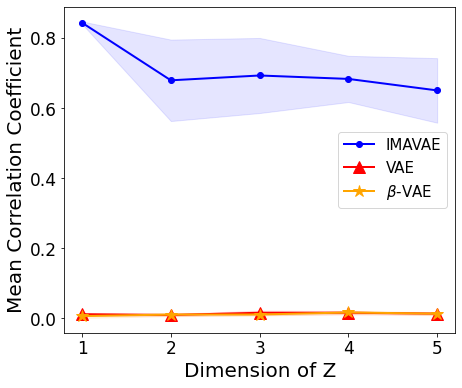

In [6]:
mcc_metrics_imavae = np.array(mcc_metrics_imavae)
mcc_metrics_vae = np.array(mcc_metrics_vae)
mcc_metrics_beta_vae = np.array(mcc_metrics_beta_vae)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
ax.plot(z_m_dims, np.mean(mcc_metrics_imavae,axis=0), color='blue', lw=2, marker='.', markersize=12, label='IMAVAE')
ax.plot(z_m_dims, np.mean(mcc_metrics_vae,axis=0), color='red', lw=2, marker='^', markersize=12, label='VAE')
ax.plot(z_m_dims, np.mean(mcc_metrics_beta_vae,axis=0), color='orange', lw=2, marker='*', markersize=12, label=r'$\beta$-VAE')
ax.fill_between(
    z_m_dims, 
    np.mean(mcc_metrics_imavae,axis=0)-np.std(mcc_metrics_imavae,axis=0), 
    np.mean(mcc_metrics_imavae,axis=0)+np.std(mcc_metrics_imavae,axis=0), 
    color='blue', alpha=0.1
)
ax.fill_between(
    z_m_dims, 
    np.mean(mcc_metrics_vae,axis=0)-np.std(mcc_metrics_vae,axis=0), 
    np.mean(mcc_metrics_vae,axis=0)+np.std(mcc_metrics_vae,axis=0), 
    color='red', alpha=0.1
)
ax.fill_between(
    z_m_dims, 
    np.mean(mcc_metrics_beta_vae,axis=0)-np.std(mcc_metrics_beta_vae,axis=0), 
    np.mean(mcc_metrics_beta_vae,axis=0)+np.std(mcc_metrics_beta_vae,axis=0), 
    color='orange', alpha=0.1
)
ax.locator_params(nbins=5, axis='x')
ax.locator_params(nbins=5, axis='y')
ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_xlabel('Dimension of Z', fontsize=20)
ax.set_ylabel('Mean Correlation Coefficient', fontsize=20)
ax.legend(prop={'size': 15})
plt.savefig('./Figures/mcc_varying_dz_with_covariate.png', dpi=600)

## Fit IMAVAE on the data with different number of training epochs and $d_Z = 2$

In [7]:
num_runs = 5
z_m_dim = 2
mcc_metrics_imavae = []
num_epochs = [5,10,20,40,60,80]

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, epochs in enumerate(num_epochs):
        T, X, Z = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], 
        Y, W = data[z_m_dim]['Y'], data[z_m_dim]['W']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                       optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., anneal=False)
        WT = np.concatenate([T,W], axis=1)
        _ = imavae.fit(
            X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
            lr=1e-5, n_epochs=epochs, pretrain=False, verbose=1, 
            best_model_name="best_model_with_covariate.pt"
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(t0))
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(t1))
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_imavae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 4, Best Epoch: 2, Best Recon MSE: 0.345172, Best Pred Metric [2.3089097, 


Saving the last epoch with training MSE: 0.218615 and Pred Metric: [6.2229295, 6.2229295]
Loaded the best model from Epoch: 2 with MSE: 0.345172 and Pred Metric: [2.3089097, 2.3089097]
Beginning Training


Epoch: 9, Best Epoch: 2, Best Recon MSE: 0.330879, Best Pred Metric [2.7351036, 


Saving the last epoch with training MSE: 0.143301 and Pred Metric: [3.2706132, 3.2706132]
Loaded the best model from Epoch: 2 with MSE: 0.330879 and Pred Metric: [2.7351036, 2.7351036]
Beginning Training


Epoch: 19, Best Epoch: 3, Best Recon MSE: 0.356068, Best Pred Metric [1.6918274,


Saving the last epoch with training MSE: 0.119571 and Pred Metric: [2.2521558, 2.2521558]
Loaded the best model from Epoch: 3 with MSE: 0.356068 and Pred Metric: [1.6918274, 1.6918274]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.107555, Best Pred Metric [0.3216842


Saving the last epoch with training MSE: 0.107555 and Pred Metric: [0.3216842, 0.3216842]
Loaded the best model from Epoch: 39 with MSE: 0.107555 and Pred Metric: [0.3216842, 0.3216842]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.106511, Best Pred Metric [0.1411141


Saving the last epoch with training MSE: 0.106511 and Pred Metric: [0.1411141, 0.1411141]
Loaded the best model from Epoch: 59 with MSE: 0.106511 and Pred Metric: [0.1411141, 0.1411141]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.105095, Best Pred Metric [0.1389900


Saving the last epoch with training MSE: 0.105095 and Pred Metric: [0.13899004, 0.13899004]
Loaded the best model from Epoch: 79 with MSE: 0.105095 and Pred Metric: [0.13899004, 0.13899004]
Run 2 
Beginning Training


Epoch: 4, Best Epoch: 3, Best Recon MSE: 0.316787, Best Pred Metric [4.733804, 4


Saving the last epoch with training MSE: 0.263185 and Pred Metric: [6.3045444, 6.3045444]
Loaded the best model from Epoch: 3 with MSE: 0.316787 and Pred Metric: [4.733804, 4.733804]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.123636, Best Pred Metric [6.110821, 6


Saving the last epoch with training MSE: 0.123636 and Pred Metric: [6.110821, 6.110821]
Loaded the best model from Epoch: 9 with MSE: 0.123636 and Pred Metric: [6.110821, 6.110821]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.116353, Best Pred Metric [5.0059423


Saving the last epoch with training MSE: 0.116353 and Pred Metric: [5.0059423, 5.0059423]
Loaded the best model from Epoch: 19 with MSE: 0.116353 and Pred Metric: [5.0059423, 5.0059423]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.111639, Best Pred Metric [0.2159165


Saving the last epoch with training MSE: 0.111639 and Pred Metric: [0.21591654, 0.21591654]
Loaded the best model from Epoch: 39 with MSE: 0.111639 and Pred Metric: [0.21591654, 0.21591654]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.109565, Best Pred Metric [0.1356654


Saving the last epoch with training MSE: 0.109565 and Pred Metric: [0.13566549, 0.13566549]
Loaded the best model from Epoch: 59 with MSE: 0.109565 and Pred Metric: [0.13566549, 0.13566549]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.105072, Best Pred Metric [0.1587157


Saving the last epoch with training MSE: 0.105072 and Pred Metric: [0.15871574, 0.15871574]
Loaded the best model from Epoch: 79 with MSE: 0.105072 and Pred Metric: [0.15871574, 0.15871574]
Run 3 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.30935, Best Pred Metric [11.638344, 1


Saving the last epoch with training MSE: 0.30935 and Pred Metric: [11.638344, 11.638344]
Loaded the best model from Epoch: 4 with MSE: 0.30935 and Pred Metric: [11.638344, 11.638344]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.205782, Best Pred Metric [3.831102, 3


Saving the last epoch with training MSE: 0.205782 and Pred Metric: [3.831102, 3.831102]
Loaded the best model from Epoch: 9 with MSE: 0.205782 and Pred Metric: [3.831102, 3.831102]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.114289, Best Pred Metric [2.4527996


Saving the last epoch with training MSE: 0.114289 and Pred Metric: [2.4527996, 2.4527996]
Loaded the best model from Epoch: 19 with MSE: 0.114289 and Pred Metric: [2.4527996, 2.4527996]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.111874, Best Pred Metric [0.2069109


Saving the last epoch with training MSE: 0.111874 and Pred Metric: [0.20691097, 0.20691097]
Loaded the best model from Epoch: 39 with MSE: 0.111874 and Pred Metric: [0.20691097, 0.20691097]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.107222, Best Pred Metric [0.2181817


Saving the last epoch with training MSE: 0.107222 and Pred Metric: [0.21818173, 0.21818173]
Loaded the best model from Epoch: 59 with MSE: 0.107222 and Pred Metric: [0.21818173, 0.21818173]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.104238, Best Pred Metric [0.1314331


Saving the last epoch with training MSE: 0.104238 and Pred Metric: [0.13143313, 0.13143313]
Loaded the best model from Epoch: 79 with MSE: 0.104238 and Pred Metric: [0.13143313, 0.13143313]
Run 4 
Beginning Training


Epoch: 4, Best Epoch: 1, Best Recon MSE: 0.356843, Best Pred Metric [8.643298, 8


Saving the last epoch with training MSE: 0.172926 and Pred Metric: [10.132901, 10.132901]
Loaded the best model from Epoch: 1 with MSE: 0.356843 and Pred Metric: [8.643298, 8.643298]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.126182, Best Pred Metric [2.9632754, 


Saving the last epoch with training MSE: 0.126182 and Pred Metric: [2.9632754, 2.9632754]
Loaded the best model from Epoch: 9 with MSE: 0.126182 and Pred Metric: [2.9632754, 2.9632754]
Beginning Training


Epoch: 19, Best Epoch: 2, Best Recon MSE: 0.354561, Best Pred Metric [1.2829312,


Saving the last epoch with training MSE: 0.117013 and Pred Metric: [2.317719, 2.317719]
Loaded the best model from Epoch: 2 with MSE: 0.354561 and Pred Metric: [1.2829312, 1.2829312]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.10684, Best Pred Metric [0.3492288,


Saving the last epoch with training MSE: 0.10684 and Pred Metric: [0.3492288, 0.3492288]
Loaded the best model from Epoch: 39 with MSE: 0.10684 and Pred Metric: [0.3492288, 0.3492288]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.10711, Best Pred Metric [0.16773526


Saving the last epoch with training MSE: 0.10711 and Pred Metric: [0.16773526, 0.16773526]
Loaded the best model from Epoch: 59 with MSE: 0.10711 and Pred Metric: [0.16773526, 0.16773526]
Beginning Training


Epoch: 79, Best Epoch: 78, Best Recon MSE: 0.104042, Best Pred Metric [0.1357998


Saving the last epoch with training MSE: 0.104182 and Pred Metric: [0.13635403, 0.13635403]
Loaded the best model from Epoch: 78 with MSE: 0.104042 and Pred Metric: [0.13579987, 0.13579987]
Run 5 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.364449, Best Pred Metric [6.1734705, 


Saving the last epoch with training MSE: 0.364449 and Pred Metric: [6.1734705, 6.1734705]
Loaded the best model from Epoch: 4 with MSE: 0.364449 and Pred Metric: [6.1734705, 6.1734705]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.245737, Best Pred Metric [5.6270375, 


Saving the last epoch with training MSE: 0.245737 and Pred Metric: [5.6270375, 5.6270375]
Loaded the best model from Epoch: 9 with MSE: 0.245737 and Pred Metric: [5.6270375, 5.6270375]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.112476, Best Pred Metric [2.9250495


Saving the last epoch with training MSE: 0.112476 and Pred Metric: [2.9250495, 2.9250495]
Loaded the best model from Epoch: 19 with MSE: 0.112476 and Pred Metric: [2.9250495, 2.9250495]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.109049, Best Pred Metric [1.6561084


Saving the last epoch with training MSE: 0.109049 and Pred Metric: [1.6561084, 1.6561084]
Loaded the best model from Epoch: 39 with MSE: 0.109049 and Pred Metric: [1.6561084, 1.6561084]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.107775, Best Pred Metric [0.2297491


Saving the last epoch with training MSE: 0.107775 and Pred Metric: [0.22974914, 0.22974914]
Loaded the best model from Epoch: 59 with MSE: 0.107775 and Pred Metric: [0.22974914, 0.22974914]
Beginning Training


Epoch: 79, Best Epoch: 78, Best Recon MSE: 0.105699, Best Pred Metric [0.1351013

Saving the last epoch with training MSE: 0.105752 and Pred Metric: [0.13533512, 0.13533512]
Loaded the best model from Epoch: 78 with MSE: 0.105699 and Pred Metric: [0.13510133, 0.13510133]


## Fit regular VAE and $\beta$-VAE with different number of training epochs and $d_Z = 2$

In [8]:
# VAE
num_runs = 5
z_m_dim = 2
mcc_metrics_vae = []
num_epochs = [5,10,20,40,60,80]

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, epochs in enumerate(num_epochs):
        T, X, Z = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], 
        Y, W = data[z_m_dim]['Y'], data[z_m_dim]['W']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                        optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., 
                        identifiable=False, prior_scale=0.01, anneal=False)
        WT = np.concatenate([T,W], axis=1)
        _ = imavae.fit(
            X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
            lr=1e-5, n_epochs=epochs, pretrain=False, verbose=1, 
            best_model_name="best_model_with_covariate.pt"
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_vae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.472684, Best Pred Metric [8.447133, 8


Saving the last epoch with training MSE: 0.472684 and Pred Metric: [8.447133, 8.447133]
Loaded the best model from Epoch: 4 with MSE: 0.472684 and Pred Metric: [8.447133, 8.447133]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.375604, Best Pred Metric [6.873414, 6


Saving the last epoch with training MSE: 0.375604 and Pred Metric: [6.873414, 6.873414]
Loaded the best model from Epoch: 9 with MSE: 0.375604 and Pred Metric: [6.873414, 6.873414]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.174738, Best Pred Metric [0.5368039


Saving the last epoch with training MSE: 0.174738 and Pred Metric: [0.5368039, 0.5368039]
Loaded the best model from Epoch: 19 with MSE: 0.174738 and Pred Metric: [0.5368039, 0.5368039]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.125307, Best Pred Metric [0.3053428


Saving the last epoch with training MSE: 0.125307 and Pred Metric: [0.30534285, 0.30534285]
Loaded the best model from Epoch: 39 with MSE: 0.125307 and Pred Metric: [0.30534285, 0.30534285]
Beginning Training


Epoch: 59, Best Epoch: 58, Best Recon MSE: 0.1159, Best Pred Metric [0.17102572,


Saving the last epoch with training MSE: 0.11651 and Pred Metric: [0.17295252, 0.17295252]
Loaded the best model from Epoch: 58 with MSE: 0.1159 and Pred Metric: [0.17102572, 0.17102572]
Beginning Training


Epoch: 79, Best Epoch: 78, Best Recon MSE: 0.111046, Best Pred Metric [0.1676398


Saving the last epoch with training MSE: 0.112302 and Pred Metric: [0.1714104, 0.1714104]
Loaded the best model from Epoch: 78 with MSE: 0.111046 and Pred Metric: [0.1676398, 0.1676398]
Run 2 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.500563, Best Pred Metric [5.185112, 5


Saving the last epoch with training MSE: 0.500563 and Pred Metric: [5.185112, 5.185112]
Loaded the best model from Epoch: 4 with MSE: 0.500563 and Pred Metric: [5.185112, 5.185112]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.360364, Best Pred Metric [5.7061243, 


Saving the last epoch with training MSE: 0.360364 and Pred Metric: [5.7061243, 5.7061243]
Loaded the best model from Epoch: 9 with MSE: 0.360364 and Pred Metric: [5.7061243, 5.7061243]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.165169, Best Pred Metric [4.503241,


Saving the last epoch with training MSE: 0.165169 and Pred Metric: [4.503241, 4.503241]
Loaded the best model from Epoch: 19 with MSE: 0.165169 and Pred Metric: [4.503241, 4.503241]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.128107, Best Pred Metric [0.2922837


Saving the last epoch with training MSE: 0.128107 and Pred Metric: [0.29228374, 0.29228374]
Loaded the best model from Epoch: 39 with MSE: 0.128107 and Pred Metric: [0.29228374, 0.29228374]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.116339, Best Pred Metric [0.4312276


Saving the last epoch with training MSE: 0.116339 and Pred Metric: [0.43122762, 0.43122762]
Loaded the best model from Epoch: 59 with MSE: 0.116339 and Pred Metric: [0.43122762, 0.43122762]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.113154, Best Pred Metric [0.1937433


Saving the last epoch with training MSE: 0.113154 and Pred Metric: [0.19374335, 0.19374335]
Loaded the best model from Epoch: 79 with MSE: 0.113154 and Pred Metric: [0.19374335, 0.19374335]
Run 3 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.645792, Best Pred Metric [5.6600885, 


Saving the last epoch with training MSE: 0.645792 and Pred Metric: [5.6600885, 5.6600885]
Loaded the best model from Epoch: 4 with MSE: 0.645792 and Pred Metric: [5.6600885, 5.6600885]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.355554, Best Pred Metric [7.7869062, 


Saving the last epoch with training MSE: 0.355554 and Pred Metric: [7.7869062, 7.7869062]
Loaded the best model from Epoch: 9 with MSE: 0.355554 and Pred Metric: [7.7869062, 7.7869062]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.236568, Best Pred Metric [2.8361614


Saving the last epoch with training MSE: 0.236568 and Pred Metric: [2.8361614, 2.8361614]
Loaded the best model from Epoch: 19 with MSE: 0.236568 and Pred Metric: [2.8361614, 2.8361614]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.173289, Best Pred Metric [0.4125958


Saving the last epoch with training MSE: 0.173289 and Pred Metric: [0.41259587, 0.41259587]
Loaded the best model from Epoch: 39 with MSE: 0.173289 and Pred Metric: [0.41259587, 0.41259587]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.114726, Best Pred Metric [0.2488494


Saving the last epoch with training MSE: 0.114726 and Pred Metric: [0.24884945, 0.24884945]
Loaded the best model from Epoch: 59 with MSE: 0.114726 and Pred Metric: [0.24884945, 0.24884945]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.112287, Best Pred Metric [0.2391050


Saving the last epoch with training MSE: 0.112287 and Pred Metric: [0.23910502, 0.23910502]
Loaded the best model from Epoch: 79 with MSE: 0.112287 and Pred Metric: [0.23910502, 0.23910502]
Run 4 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.668543, Best Pred Metric [3.2015722, 


Saving the last epoch with training MSE: 0.668543 and Pred Metric: [3.2015722, 3.2015722]
Loaded the best model from Epoch: 4 with MSE: 0.668543 and Pred Metric: [3.2015722, 3.2015722]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.369715, Best Pred Metric [9.826892, 9


Saving the last epoch with training MSE: 0.369715 and Pred Metric: [9.826892, 9.826892]
Loaded the best model from Epoch: 9 with MSE: 0.369715 and Pred Metric: [9.826892, 9.826892]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.155953, Best Pred Metric [1.2180231


Saving the last epoch with training MSE: 0.155953 and Pred Metric: [1.2180231, 1.2180231]
Loaded the best model from Epoch: 19 with MSE: 0.155953 and Pred Metric: [1.2180231, 1.2180231]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.124822, Best Pred Metric [0.6779427


Saving the last epoch with training MSE: 0.124822 and Pred Metric: [0.6779427, 0.6779427]
Loaded the best model from Epoch: 39 with MSE: 0.124822 and Pred Metric: [0.6779427, 0.6779427]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.113729, Best Pred Metric [0.3006604


Saving the last epoch with training MSE: 0.113729 and Pred Metric: [0.3006604, 0.3006604]
Loaded the best model from Epoch: 59 with MSE: 0.113729 and Pred Metric: [0.3006604, 0.3006604]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.111595, Best Pred Metric [0.1945166


Saving the last epoch with training MSE: 0.111595 and Pred Metric: [0.19451664, 0.19451664]
Loaded the best model from Epoch: 79 with MSE: 0.111595 and Pred Metric: [0.19451664, 0.19451664]
Run 5 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 1.00025, Best Pred Metric [2.6261706, 2


Saving the last epoch with training MSE: 1.00025 and Pred Metric: [2.6261706, 2.6261706]
Loaded the best model from Epoch: 4 with MSE: 1.00025 and Pred Metric: [2.6261706, 2.6261706]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.367479, Best Pred Metric [8.746877, 8


Saving the last epoch with training MSE: 0.367479 and Pred Metric: [8.746877, 8.746877]
Loaded the best model from Epoch: 9 with MSE: 0.367479 and Pred Metric: [8.746877, 8.746877]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.189831, Best Pred Metric [1.0587385


Saving the last epoch with training MSE: 0.189831 and Pred Metric: [1.0587385, 1.0587385]
Loaded the best model from Epoch: 19 with MSE: 0.189831 and Pred Metric: [1.0587385, 1.0587385]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.117233, Best Pred Metric [0.4942112


Saving the last epoch with training MSE: 0.117233 and Pred Metric: [0.49421126, 0.49421126]
Loaded the best model from Epoch: 39 with MSE: 0.117233 and Pred Metric: [0.49421126, 0.49421126]
Beginning Training


Epoch: 59, Best Epoch: 58, Best Recon MSE: 0.125779, Best Pred Metric [0.4017734


Saving the last epoch with training MSE: 0.123431 and Pred Metric: [0.40772355, 0.40772355]
Loaded the best model from Epoch: 58 with MSE: 0.125779 and Pred Metric: [0.4017734, 0.4017734]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.111314, Best Pred Metric [0.2097179

Saving the last epoch with training MSE: 0.111314 and Pred Metric: [0.20971793, 0.20971793]
Loaded the best model from Epoch: 79 with MSE: 0.111314 and Pred Metric: [0.20971793, 0.20971793]


In [9]:
# beta-VAE
num_runs = 5
z_m_dim = 2
mcc_metrics_beta_vae = []
num_epochs = [5,10,20,40,60,80]

for i in range(num_runs):
    print(f"Run {i+1} \n=========================================")
    mcc_metric = []
    for idx, epochs in enumerate(num_epochs):
        T, X, Z = data[z_m_dim]['T'], data[z_m_dim]['X'], data[z_m_dim]['Z'], 
        Y, W = data[z_m_dim]['Y'], data[z_m_dim]['W']
        imavae = IMAVAE(n_components=z_m_dim, n_sup_networks=z_m_dim, n_hidden_layers=2, hidden_dim=25, 
                        optim_name='Adam', recon_weight=1., elbo_weight=1., sup_weight=1., 
                        identifiable=False, beta=4.0, prior_scale=0.01, anneal=False)
        WT = np.concatenate([T,W], axis=1)
        _ = imavae.fit(
            X, WT, Y, X_val=X, aux_val=WT, y_val=Y, 
            lr=1e-5, n_epochs=epochs, pretrain=False, verbose=1, 
            best_model_name="best_model_with_covariate.pt"
        )
        with torch.no_grad():
            t0, t1 = torch.zeros(N, 1), torch.ones(N, 1)
            t0, t1 = torch.cat([t0, torch.tensor(W).float()], dim=1), torch.cat([t1, torch.tensor(W).float()], dim=1)
            z_m0_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            z_m1_pred = imavae.prior_dist.sample(*imavae.ivae.prior_params(), size=N)
            # Estimated z_m for factual outcomes
            z_m_pred = torch.stack([z_m0_pred[i,:] if T[i,0] == 0 else z_m1_pred[i,:] for i in range(N)])
        mcc_metric.append(mcc(Z, z_m_pred.numpy()))
    mcc_metrics_beta_vae.append(mcc_metric)

Run 1 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.999506, Best Pred Metric [11.403838, 


Saving the last epoch with training MSE: 0.999506 and Pred Metric: [11.403838, 11.403838]
Loaded the best model from Epoch: 4 with MSE: 0.999506 and Pred Metric: [11.403838, 11.403838]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.990629, Best Pred Metric [9.790152, 9


Saving the last epoch with training MSE: 0.990629 and Pred Metric: [9.790152, 9.790152]
Loaded the best model from Epoch: 9 with MSE: 0.990629 and Pred Metric: [9.790152, 9.790152]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.374086, Best Pred Metric [3.8292272


Saving the last epoch with training MSE: 0.374086 and Pred Metric: [3.8292272, 3.8292272]
Loaded the best model from Epoch: 19 with MSE: 0.374086 and Pred Metric: [3.8292272, 3.8292272]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.187044, Best Pred Metric [1.0125804


Saving the last epoch with training MSE: 0.187044 and Pred Metric: [1.0125804, 1.0125804]
Loaded the best model from Epoch: 39 with MSE: 0.187044 and Pred Metric: [1.0125804, 1.0125804]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.122463, Best Pred Metric [0.2337298


Saving the last epoch with training MSE: 0.122463 and Pred Metric: [0.23372982, 0.23372982]
Loaded the best model from Epoch: 59 with MSE: 0.122463 and Pred Metric: [0.23372982, 0.23372982]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.11594, Best Pred Metric [0.22509761


Saving the last epoch with training MSE: 0.11594 and Pred Metric: [0.22509761, 0.22509761]
Loaded the best model from Epoch: 79 with MSE: 0.11594 and Pred Metric: [0.22509761, 0.22509761]
Run 2 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 1.00172, Best Pred Metric [18.744146, 1


Saving the last epoch with training MSE: 1.00172 and Pred Metric: [18.744146, 18.744146]
Loaded the best model from Epoch: 4 with MSE: 1.00172 and Pred Metric: [18.744146, 18.744146]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.999561, Best Pred Metric [6.2620378, 


Saving the last epoch with training MSE: 0.999561 and Pred Metric: [6.2620378, 6.2620378]
Loaded the best model from Epoch: 9 with MSE: 0.999561 and Pred Metric: [6.2620378, 6.2620378]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.369885, Best Pred Metric [4.854795,


Saving the last epoch with training MSE: 0.369885 and Pred Metric: [4.854795, 4.854795]
Loaded the best model from Epoch: 19 with MSE: 0.369885 and Pred Metric: [4.854795, 4.854795]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.940892, Best Pred Metric [2.4216628


Saving the last epoch with training MSE: 0.940892 and Pred Metric: [2.4216628, 2.4216628]
Loaded the best model from Epoch: 39 with MSE: 0.940892 and Pred Metric: [2.4216628, 2.4216628]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.148475, Best Pred Metric [0.2850606


Saving the last epoch with training MSE: 0.148475 and Pred Metric: [0.28506064, 0.28506064]
Loaded the best model from Epoch: 59 with MSE: 0.148475 and Pred Metric: [0.28506064, 0.28506064]
Beginning Training


Epoch: 79, Best Epoch: 77, Best Recon MSE: 0.122238, Best Pred Metric [0.1728881


Saving the last epoch with training MSE: 0.121806 and Pred Metric: [0.17440115, 0.17440115]
Loaded the best model from Epoch: 77 with MSE: 0.122238 and Pred Metric: [0.17288816, 0.17288816]
Run 3 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.999767, Best Pred Metric [11.098419, 


Saving the last epoch with training MSE: 0.999767 and Pred Metric: [11.098419, 11.098419]
Loaded the best model from Epoch: 4 with MSE: 0.999767 and Pred Metric: [11.098419, 11.098419]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.994361, Best Pred Metric [7.579373, 7


Saving the last epoch with training MSE: 0.994361 and Pred Metric: [7.579373, 7.579373]
Loaded the best model from Epoch: 9 with MSE: 0.994361 and Pred Metric: [7.579373, 7.579373]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.367637, Best Pred Metric [1.9686699


Saving the last epoch with training MSE: 0.367637 and Pred Metric: [1.9686699, 1.9686699]
Loaded the best model from Epoch: 19 with MSE: 0.367637 and Pred Metric: [1.9686699, 1.9686699]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.212704, Best Pred Metric [0.4463310


Saving the last epoch with training MSE: 0.212704 and Pred Metric: [0.44633102, 0.44633102]
Loaded the best model from Epoch: 39 with MSE: 0.212704 and Pred Metric: [0.44633102, 0.44633102]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.145884, Best Pred Metric [0.4137815


Saving the last epoch with training MSE: 0.145884 and Pred Metric: [0.4137815, 0.4137815]
Loaded the best model from Epoch: 59 with MSE: 0.145884 and Pred Metric: [0.4137815, 0.4137815]
Beginning Training


Epoch: 79, Best Epoch: 78, Best Recon MSE: 0.135234, Best Pred Metric [0.2084509


Saving the last epoch with training MSE: 0.135269 and Pred Metric: [0.22182141, 0.22182141]
Loaded the best model from Epoch: 78 with MSE: 0.135234 and Pred Metric: [0.20845097, 0.20845097]
Run 4 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.999853, Best Pred Metric [7.5091352, 


Saving the last epoch with training MSE: 0.999853 and Pred Metric: [7.5091352, 7.5091352]
Loaded the best model from Epoch: 4 with MSE: 0.999853 and Pred Metric: [7.5091352, 7.5091352]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.999767, Best Pred Metric [4.617689, 4


Saving the last epoch with training MSE: 0.999767 and Pred Metric: [4.617689, 4.617689]
Loaded the best model from Epoch: 9 with MSE: 0.999767 and Pred Metric: [4.617689, 4.617689]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.387738, Best Pred Metric [5.652811,


Saving the last epoch with training MSE: 0.387738 and Pred Metric: [5.652811, 5.652811]
Loaded the best model from Epoch: 19 with MSE: 0.387738 and Pred Metric: [5.652811, 5.652811]
Beginning Training


Epoch: 39, Best Epoch: 38, Best Recon MSE: 0.216002, Best Pred Metric [0.8194194


Saving the last epoch with training MSE: 0.212306 and Pred Metric: [0.83858275, 0.83858275]
Loaded the best model from Epoch: 38 with MSE: 0.216002 and Pred Metric: [0.81941944, 0.81941944]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.161797, Best Pred Metric [0.2780048


Saving the last epoch with training MSE: 0.161797 and Pred Metric: [0.27800488, 0.27800488]
Loaded the best model from Epoch: 59 with MSE: 0.161797 and Pred Metric: [0.27800488, 0.27800488]
Beginning Training


Epoch: 79, Best Epoch: 79, Best Recon MSE: 0.138258, Best Pred Metric [0.1739904


Saving the last epoch with training MSE: 0.138258 and Pred Metric: [0.17399041, 0.17399041]
Loaded the best model from Epoch: 79 with MSE: 0.138258 and Pred Metric: [0.17399041, 0.17399041]
Run 5 
Beginning Training


Epoch: 4, Best Epoch: 4, Best Recon MSE: 0.995528, Best Pred Metric [6.070164, 6


Saving the last epoch with training MSE: 0.995528 and Pred Metric: [6.070164, 6.070164]
Loaded the best model from Epoch: 4 with MSE: 0.995528 and Pred Metric: [6.070164, 6.070164]
Beginning Training


Epoch: 9, Best Epoch: 9, Best Recon MSE: 0.732384, Best Pred Metric [2.452473, 2


Saving the last epoch with training MSE: 0.732384 and Pred Metric: [2.452473, 2.452473]
Loaded the best model from Epoch: 9 with MSE: 0.732384 and Pred Metric: [2.452473, 2.452473]
Beginning Training


Epoch: 19, Best Epoch: 19, Best Recon MSE: 0.379477, Best Pred Metric [1.1171232


Saving the last epoch with training MSE: 0.379477 and Pred Metric: [1.1171232, 1.1171232]
Loaded the best model from Epoch: 19 with MSE: 0.379477 and Pred Metric: [1.1171232, 1.1171232]
Beginning Training


Epoch: 39, Best Epoch: 39, Best Recon MSE: 0.20814, Best Pred Metric [0.28052533


Saving the last epoch with training MSE: 0.20814 and Pred Metric: [0.28052533, 0.28052533]
Loaded the best model from Epoch: 39 with MSE: 0.20814 and Pred Metric: [0.28052533, 0.28052533]
Beginning Training


Epoch: 59, Best Epoch: 59, Best Recon MSE: 0.128531, Best Pred Metric [0.6324118


Saving the last epoch with training MSE: 0.128531 and Pred Metric: [0.63241184, 0.63241184]
Loaded the best model from Epoch: 59 with MSE: 0.128531 and Pred Metric: [0.63241184, 0.63241184]
Beginning Training


Epoch: 79, Best Epoch: 78, Best Recon MSE: 0.122584, Best Pred Metric [0.1996104

Saving the last epoch with training MSE: 0.127143 and Pred Metric: [0.20161566, 0.20161566]
Loaded the best model from Epoch: 78 with MSE: 0.122584 and Pred Metric: [0.19961043, 0.19961043]


## Compare mean correlation coefficients for varying number of training epochs

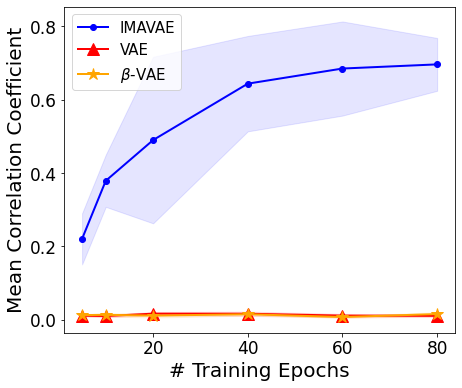

In [10]:
mcc_metrics_imavae = np.array(mcc_metrics_imavae)
mcc_metrics_vae = np.array(mcc_metrics_vae)
mcc_metrics_beta_vae = np.array(mcc_metrics_beta_vae)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
ax.plot(num_epochs, np.mean(mcc_metrics_imavae,axis=0), color='blue', lw=2, marker='.', markersize=12, label='IMAVAE')
ax.plot(num_epochs, np.mean(mcc_metrics_vae,axis=0), color='red', lw=2, marker='^', markersize=12, label='VAE')
ax.plot(num_epochs, np.mean(mcc_metrics_beta_vae,axis=0), color='orange', lw=2, marker='*', markersize=12, label=r'$\beta$-VAE')
ax.fill_between(
    num_epochs, 
    np.mean(mcc_metrics_imavae,axis=0)-np.std(mcc_metrics_imavae,axis=0), 
    np.mean(mcc_metrics_imavae,axis=0)+np.std(mcc_metrics_imavae,axis=0), 
    color='blue', alpha=0.1
)
ax.fill_between(
    num_epochs, 
    np.mean(mcc_metrics_vae,axis=0)-np.std(mcc_metrics_vae,axis=0), 
    np.mean(mcc_metrics_vae,axis=0)+np.std(mcc_metrics_vae,axis=0), 
    color='red', alpha=0.1
)
ax.fill_between(
    num_epochs, 
    np.mean(mcc_metrics_beta_vae,axis=0)-np.std(mcc_metrics_beta_vae,axis=0), 
    np.mean(mcc_metrics_beta_vae,axis=0)+np.std(mcc_metrics_beta_vae,axis=0), 
    color='orange', alpha=0.1
)
ax.locator_params(nbins=5, axis='y')
ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_xlabel('# Training Epochs', fontsize=20)
ax.set_ylabel('Mean Correlation Coefficient', fontsize=20)
ax.legend(prop={'size': 15})
plt.savefig('./Figures/mcc_varying_epochs_with_covariate.png', dpi=600)